# Identifying Entities in Healthcare Data

## Importing packages

In [21]:
#!pip install pycrf
#!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import re
from tqdm import tqdm
# Loading spacy model
model = spacy.load("en_core_web_sm")
import pandas as pd

## Data Preprocessing

### Reading the data

In [22]:
# Train data
train  = open("train_sent","r").readlines()
train = "".join(train).replace("\n"," ")
train_labels  = open("train_label","r").readlines()
train_labels = "".join(train_labels).replace("\n"," ")
# Test data
test  = open("test_sent","r").readlines()
test = "".join(test).replace("\n"," ")
test_labels  = open("test_label","r").readlines()
test_labels = "".join(test_labels).replace("\n"," ")

### Converting to required format and printing 5 sentences from training set

In [23]:
# Function for returning sentences in required format
def return_sentences(data):
    pattern = "(\s\s)" # searching for two spaces
    output_corpus = []
    start = 0
    for match in re.finditer(pattern,data):
        output_corpus.append(data[start:match.start()])
        start = match.end()
    return output_corpus

# Converting to required format
train_corpus = return_sentences(train)
train_labels = return_sentences(train_labels)
test_corpus = return_sentences(test)
test_labels = return_sentences(test_labels)

# Printing 5 sentences
for i in range(0,5):
    print(train_corpus[i])

All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )


In [24]:
print("The number of sentences in train dataset is ", len(train_corpus))
print("The number of sentences in test dataset is ", len(test_corpus))

The number of sentences in train dataset is  2599
The number of sentences in test dataset is  1056


In [25]:
print("The number of lines of labels in train dataset is ", len(train_labels))
print("The number of lines of labels in test dataset is ", len(test_labels))

The number of lines of labels in train dataset is  2599
The number of lines of labels in test dataset is  1056


## Concept Identification

### Extracting tokens which have NOUN or PROPN as their PoS tag and finding their frequency

In [26]:
# Extracting noun or propn
total_corpus = train_corpus + test_corpus
print("The total number of sentences are: ",len(total_corpus))
concept_dict = {}
for sent in tqdm(total_corpus):
    doc = model(sent)
    for token in doc:
        if token.pos_ == "NOUN" or token.pos_ == "PROPN":
            if token.text.lower() in concept_dict.keys():
                concept_dict[token.text.lower()] = concept_dict[token.text.lower()]+1
            else:
                concept_dict[token.text.lower()] = 1
print("Tokens that are noun or propn in the entire data set are: ", len(concept_dict.keys()))
print(concept_dict)


The total number of sentences are:  3655


100%|██████████| 3655/3655 [00:19<00:00, 191.33it/s]

Tokens that are noun or propn in the entire data set are:  5802
{'births': 2, 'weeks': 37, 'university': 7, 'vermont': 1, 'delivery': 22, 'route': 2, 'indication': 5, 'age': 56, 'parity': 4, 'practice': 32, 'group': 111, 'risk': 74, 'status': 17, 'rate': 68, '%': 247, 'presentation': 7, 'medicine': 42, 'patients': 507, 'arrest': 6, 'dilation': 4, 'subgroups': 4, 'rates': 35, 'care': 56, 'hospitals': 10, 'community': 16, 'groups': 34, 'trimester': 4, 'index': 14, 'afi': 7, 'temperature': 10, 'increases': 7, 'decrease': 6, 'june': 2, 'august': 6, 'period': 28, 'heat': 5, 'women': 81, 'singleton': 1, 'pregnancies': 7, 'gestation': 4, 'testing': 23, 'determinations': 2, 'ambient': 1, 'area': 13, 'day': 36, 'mean': 4, 'test': 22, 'date': 3, 'spearman': 1, 'rank': 2, 'correlation': 19, 'relationship': 14, 'account': 4, 'measure': 4, 'being': 2, 'study': 173, 'population': 31, 'diabetes': 34, 'screening': 13, 'clinic': 5, 'hadassah': 1, 'medical': 6, 'center': 10, 'year': 47, 'treatment': 304

### Printing the top 25 most common tokens with NOUN or PROPN PoS tags

In [27]:
concept_df = pd.DataFrame.from_dict(concept_dict,orient = "index")
print("The top 25 commonly occuring tokens as noun or propn are :")
concept_df.sort_values(by=list(concept_df.columns)[0],ascending=False).head(25)

The top 25 commonly occuring tokens as noun or propn are :


,0
patients,507
treatment,304
%,247
cancer,211
therapy,177
study,173
disease,149
cell,142
lung,118
group,111


## Defining features for CRF

### Getting the features for a word

In [28]:
# Getting the features for one word
def feat_word(sentence_list,position,pos):
    features = [
    "word.lower=" + sentence_list[position].lower(), # word id
    "word.pos=" + pos] # word pos
    if position == 0:
        features.append("BEG") # beginning
    elif position == len(sentence_list) - 1:
        features.append("END") # ending
    if position > 0:
        features.append("prev_word.lower=" + sentence_list[position-1].lower()) # previous word
    return features

### Getting the features for a sentence

In [29]:
# Write a code to get features for a sentence.
def get_feat_sent(sentence,nlp_model):
    sentence_list = sentence.split()
    doc = nlp_model(sentence)
    return [feat_word(sentence_list,i,doc[i].pos_) for i in range(0,len(sentence_list))]

# Printing features for one word and one sentence
print_feat = get_feat_sent(train_corpus[0],model)
print("Features for a single word :",print_feat[0])
print("Features for a single sentence: ",print_feat)

Features for a single word : ['word.lower=all', 'word.pos=DET', 'BEG']
Features for a single sentence:  [['word.lower=all', 'word.pos=DET', 'BEG'], ['word.lower=live', 'word.pos=ADJ', 'prev_word.lower=all'], ['word.lower=births', 'word.pos=NOUN', 'prev_word.lower=live'], ['word.lower=>', 'word.pos=PUNCT', 'prev_word.lower=births'], ['word.lower=or', 'word.pos=CCONJ', 'prev_word.lower=>'], ['word.lower==', 'word.pos=SYM', 'prev_word.lower=or'], ['word.lower=23', 'word.pos=NUM', 'prev_word.lower=='], ['word.lower=weeks', 'word.pos=NOUN', 'prev_word.lower=23'], ['word.lower=at', 'word.pos=ADP', 'prev_word.lower=weeks'], ['word.lower=the', 'word.pos=DET', 'prev_word.lower=at'], ['word.lower=university', 'word.pos=PROPN', 'prev_word.lower=the'], ['word.lower=of', 'word.pos=ADP', 'prev_word.lower=university'], ['word.lower=vermont', 'word.pos=PROPN', 'prev_word.lower=of'], ['word.lower=in', 'word.pos=ADP', 'prev_word.lower=vermont'], ['word.lower=1995', 'word.pos=NUM', 'prev_word.lower=in'],

### Getting the labels of a sentence

In [30]:
# Write a code to get the labels for a sentence.
def get_labels_sent(labels,sentence_pos):
    return labels[sentence_pos].split()
# Printing labels for once sentence
print(get_labels_sent(train_labels,0))

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Defining input and target variables


### Defining the input features for train and test sets

In [31]:
X_train = [get_feat_sent(sentence,model) for sentence in tqdm(train_corpus)]
X_test = [get_feat_sent(sentence,model) for sentence in tqdm(test_corpus)]

100%|██████████| 1056/1056 [00:05<00:00, 203.71it/s]


### Defining the labels as the target variable for test and the train sets

In [32]:
y_train = [get_labels_sent(train_labels,i) for i in tqdm(range(0,len(train_corpus)))]
y_test = [get_labels_sent(test_labels,i) for i in tqdm(range(0,len(test_corpus)))]

100%|██████████| 1056/1056 [00:00<00:00, 700487.91it/s]


## Building the CRF Model

In [33]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass

## Model Evaluation

### Prediction for test set

In [34]:
y_pred = crf.predict(X_test)
print("Actual labels for sentence-1 in test set: ", y_test[0])
print("Predicted labels for sentence-1 in test set: ", y_pred[0])

Actual labels for sentence-1 in test set:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted labels for sentence-1 in test set:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


### Calculating f1 score

In [35]:
print("The f1 score on the test set is : ",round(metrics.flat_f1_score(y_test, y_pred, average='weighted'),2))

The f1 score on the test set is :  0.89


## Identifying Diseases and Treatments using Custom NER

### Creating the dictionary with keys as diseases and treatment as values

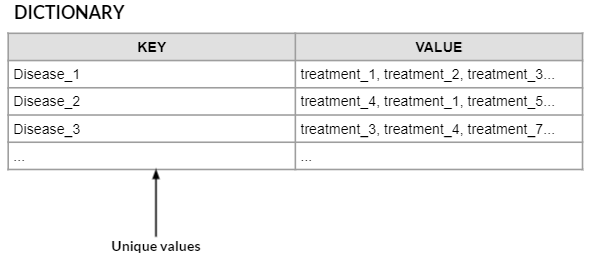

In [36]:
treat_dict = {}
for sentence,pred in zip(test_corpus,y_pred):
    treatment = []
    if "T" in pred:
        for count,i in enumerate(pred):
            if i == "T":
                treatment.append(sentence.split()[count].lower())
    treatment = ",".join(treatment)
    for count,i in enumerate(pred):
        if i == "D":
            disease = sentence.split()[count].lower()
            if disease not in treat_dict.keys():
                if len(treatment) > 0:
                    treat_dict[disease] = treatment
            else:
                treat_dict[disease] = treat_dict[disease] + "," + treatment

print(treat_dict)

{'hereditary': 'radiotherapy', 'retinoblastoma': 'radiotherapy', 'coronary-artery': 'antichlamydial,antibiotics', 'disease': 'antichlamydial,antibiotics,,,,ropinirole,monotherapy,,,,,,,,,,,,,,,,got,surgical,treatment,resection,,,allowing,neoadjuvant,therapy,platinum,dose,(,cisplatin,plus,carboplatin,),in,combination,chemotherapy,combination,therapy,with,carboplatin,,,,', 'early': 'ropinirole,monotherapy', 'parkinson': 'ropinirole,monotherapy,,,', "'s": 'ropinirole,monotherapy,,,,,,,,,laparoscopic,cholecystectomy,,interferon,alpha,,,,', 'sore': 'antibiotics,', 'throat': 'antibiotics,', 'female': 'surgical,treatment', 'stress': 'surgical,treatment,therapy,', 'urinary': 'surgical,treatment,therapy', 'incontinence': 'surgical,treatment,therapy', 'preeclampsia': 'intrauterine,insemination,with,donor,sperm,versus,intrauterine,insemination,,,,,', '(': 'intrauterine,insemination,with,donor,sperm,versus,intrauterine,insemination,got,surgical,treatment,,a,combination,chemotherapy,program,consist

### Predicting the treatment for the disease name: 'hereditary retinoblastoma'

In [37]:
print("The treatment for the disease hereditary retinoblastoma is ")
print(treat_dict["hereditary"])
print(treat_dict["retinoblastoma"])

The treatment for disease hereditary retinoblastoma is 
radiotherapy
radiotherapy
